In [217]:
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point#, Polygon, MultiPoint
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [184]:
base_path = '/home/jez/Bias_Correction/'
observations_path = f'{base_path}data/ProcessedData/NST_Observations.nc'
region_shapefile_path = f'{base_path}data/Ross_Region_Shapefile/ross_region.shp'
antarctica_shapefile_path = f'{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp'
ds = xr.open_dataset(observations_path).isel(Month=0)
# xds = xr.open_dataset(f'{base_path}data/ProcessedData/NST_Observations.nc', decode_coords="all")
region_gdf = gpd.read_file(region_shapefile_path)
antarctica_gdf = gpd.read_file(antarctica_shapefile_path)


In [185]:
point_inside = Point(180,-80.0)
point_outside = Point(180,-72.5)
point_inside_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[point_inside])
point_outside_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[point_outside])

In [186]:
points = [Point(lon,lat) for lon,lat in zip(ds['Lon(°C)'],ds['Lat(°C)'])]
points_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry=points)

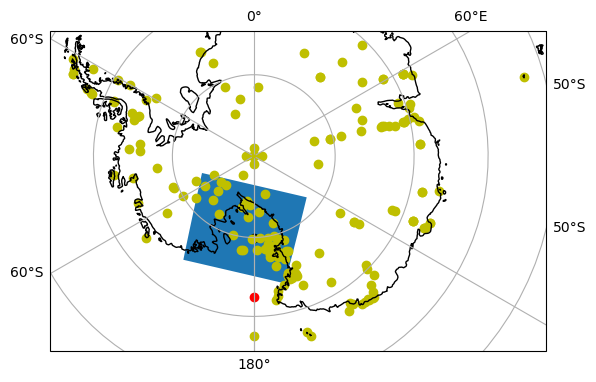

In [187]:
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90, globe=None)

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": map_proj})#, figsize=(dc, dc))
region_gdf.to_crs(map_proj).plot(ax=ax)
point_inside_gdf.to_crs(map_proj).plot(ax=ax,color='k')
point_outside_gdf.to_crs(map_proj).plot(ax=ax,color='r')
points_gdf.to_crs(map_proj).plot(ax=ax,color='y')
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True)
ax.coastlines()

In [188]:
mask = [region_gdf.to_crs(map_proj).contains(points_gdf[i:i+1].reset_index().to_crs(map_proj)) for i in range(points_gdf.shape[0])]
mask = np.array(mask).reshape(-1)

In [189]:
subset_ds = ds.sel(Station_Lower=mask)

<GeoAxesSubplot: title={'center': 'Month = 1.0'}, xlabel='Lon(°C)', ylabel='Lat(°C)'>

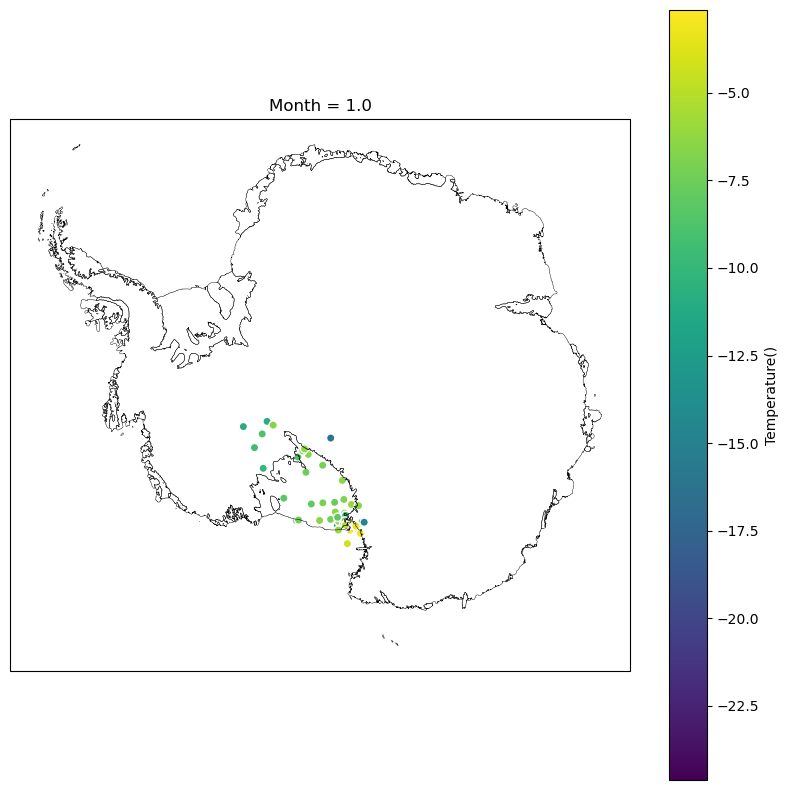

In [190]:
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)
antarctica_gdf_map_proj = antarctica_gdf.to_crs(map_proj)

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": map_proj}, figsize=(10, 10))

subset_ds.mean('Day').plot.scatter(x="Lon(°C)",y="Lat(°C)",transform=ccrs.PlateCarree(),ax=axs,hue='Temperature()')

antarctica_gdf_map_proj.boundary.plot(ax=axs, color="k", linewidth=0.3)

In [218]:
# subset_ds['Institution'] = subset_ds.Institution.astype(object)
# base_path = '/home/jez/Bias_Correction/'
# out_path = f'{base_path}data/ProcessedData/NST_Observations_Subset.nc'
# ds.to_netcdf(out_path)